# Graph My Task Statistics

We'll use the matplotlib [Stacked Area Plot](https://www.python-graph-gallery.com/stacked-area-plot/) to visualize the accumulation of incoming vs. completed tasks over time.

In [1]:
%matplotlib widget

import math
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import mplcursors

from main import AmazingCloudAntClient

client = AmazingCloudAntClient()

# Get tasks since...
since = dt.datetime(2023, 1, 1).timestamp() * 1000
chart_data = client.get_task_stats_for_chart(since=since)

date_fmt = DateFormatter("%Y-%m-%d")

Avg New Tasks per Day: 2.9375
Avg Completed Tasks per Day: 4.166666666666667
Avg Backlog Increase: -1.2291666666666667


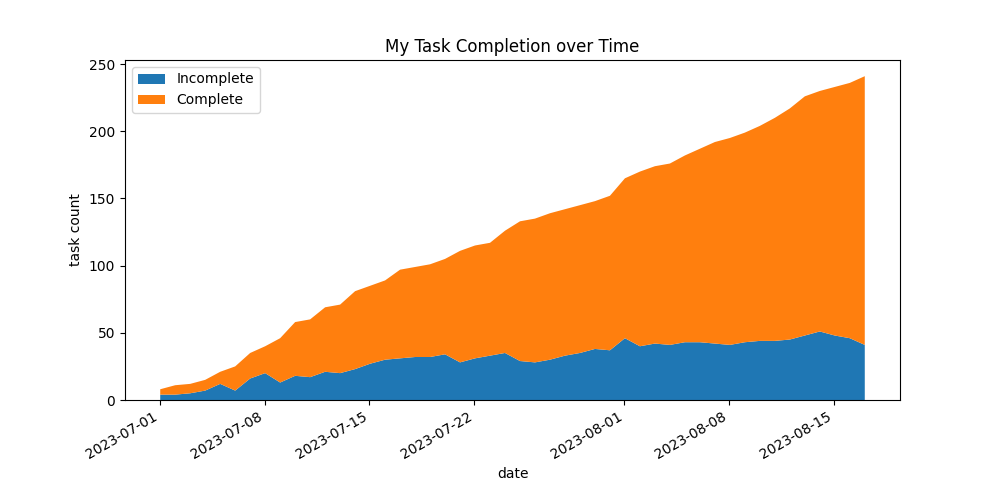

In [2]:
%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Set up figure
ax.stackplot(
    chart_data["dates"],
    chart_data["incomplete"],
    chart_data["complete"],
    labels=['Incomplete','Complete'],
)
plt.legend(loc='upper left')
plt.title("My Task Completion over Time")
plt.xlabel('date')
plt.ylabel('task count')

# Format Dates
fig.autofmt_xdate()
ax.xaxis.set_major_formatter(date_fmt)

mplcursors.cursor(hover=True)

# Quick Stats
cpd = chart_data["complete"][-1] / len(chart_data["dates"])
ipd = (chart_data["incomplete"][-1] - 100) / len(chart_data["dates"])
print("Avg New Tasks per Day:", cpd+ipd)
print("Avg Completed Tasks per Day:", cpd)
print("Avg Backlog Increase:", ipd)

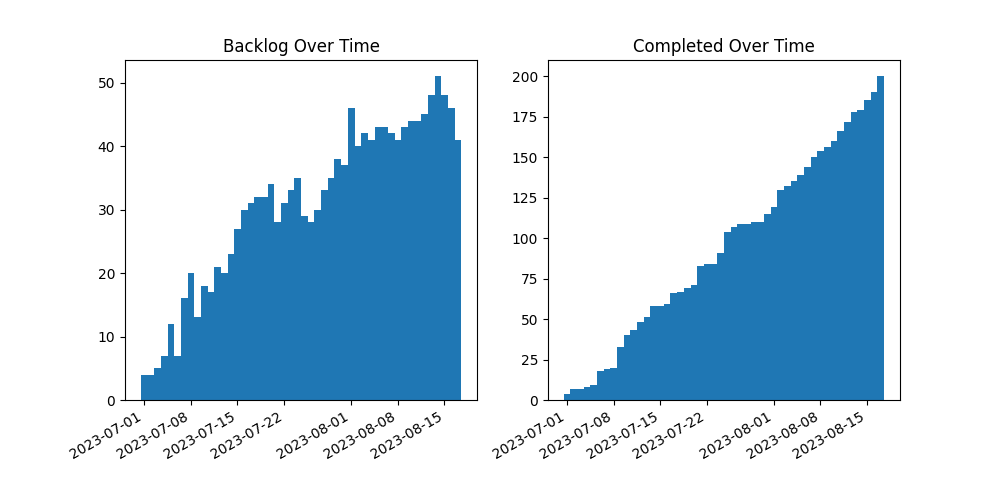

In [3]:
# Set up figures
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.title.set_text("Backlog Over Time")
ax2.title.set_text("Completed Over Time")
ax1.bar(chart_data["dates"], chart_data["incomplete"], width=1)
ax2.bar(chart_data["dates"], chart_data["complete"], width=1)

# Format dates
fig.autofmt_xdate()
date_form = DateFormatter("%Y-%m-%d")
ax1.xaxis.set_major_formatter(date_form)
ax2.xaxis.set_major_formatter(date_form)

# mplcursors.cursor(hover=True)

In [4]:
# Tasks Added / Removed Today
today = dt.datetime.now()
week_ago = today - dt.timedelta(days=7)
today_stats = client.get_tasks_added_removed_between(start=week_ago, end=today)

print("THIS WEEK'S TASK STATS")

print(f'{ len(today_stats["created"]) } Task/s Created')
for t in today_stats["created"][:5]:
    print(f'  - { t["doc"]["title"] }')

print('')

print(f'{ len(today_stats["completed"]) } Task/s Completed')
for t in today_stats["completed"][:5]:
    print(f'  - { t["doc"]["title"] }')

THIS WEEK'S TASK STATS
34 Task/s Created
  - Weekly Review
  - Reminder: Audio Recording > Audio Journal > 2021
  - Jury Duty - Call after 5pm: 202-354-3518 | 103895809
  - Review and think about our financial projections on my own [Slack Msg from Neil Shah](https://thinknimble.slack.com/archives/CNYHCPHRV/p1650463258685949)
  - Review Chaos Pod Forecast

33 Task/s Completed
  - Mighty Brother: Update QBO Transactions
  - Trim Beard
  - Weekly Review
  - Reminder: Audio Recording > Audio Journal > 2021
  - Jury Duty - Call after 5pm: 202-354-3518 | 103895809


NOTE: Negative cycle times are recurring tasks that were marked 'done' before the date of recurrence.

Q1: 0.23714902199074075
Q3: 4.258626791087964
IQR: 4.021477769097223
outer_fence: 16.32306009837963
95th: 44.12180772858796
99th: 257.2847772453704

334 outliers of 3276: [16.49248732638889, 16.520068842592593, 16.581976875] ... [451.4066702777778, 523.7625834027778, 556.1934447916667]


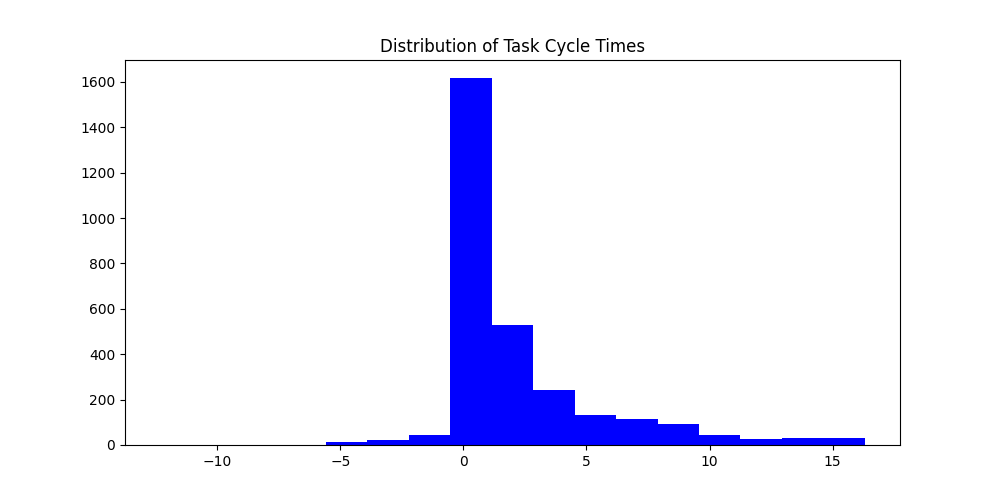

In [5]:
# Look at distribution of task cycle times
tasks = client.get_all_tasks()
cycle_times = sorted([t.cycle_time for t in tasks if t.done])

q1, q3, n5, n9 = np.percentile(cycle_times, [25, 75, 95, 99])
iqr = q3 - q1
outer_fence = q3 + 3*(iqr)

print("NOTE: Negative cycle times are recurring tasks that were marked 'done' before the date of recurrence.")

print(f"""
Q1: {q1}
Q3: {q3}
IQR: {iqr}
outer_fence: {outer_fence}
95th: {n5}
99th: {n9}
""")

outliers = sorted([c for c in cycle_times if c >= outer_fence])
print(f"{len(outliers)} outliers of {len(cycle_times)}: {outliers[:3]} ... {outliers[-3:]}")

# Filter out outliers
a = [i for i in cycle_times if i not in outliers]

# Plot it
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(a, bins=math.ceil(max(a)), histtype ='bar', facecolor='blue')
ax.title.set_text("Distribution of Task Cycle Times")


NOTE: Negative cycle times are recurring tasks that were marked 'done' before the date of recurrence.

Q1: 0.4468619560185185
Q3: 6.530770434027778
IQR: 6.083908478009259
outer_fence: 24.782495868055555
95th: 67.87948739699058
99th: 260.0492275039352

251 outliers of 2342: [<main.Task object at 0x11c456940>, <main.Task object at 0x11c441a60>, <main.Task object at 0x11c4f97c0>] ... [<main.Task object at 0x11c4e99a0>, <main.Task object at 0x11c4ee0a0>, <main.Task object at 0x11c4446a0>]


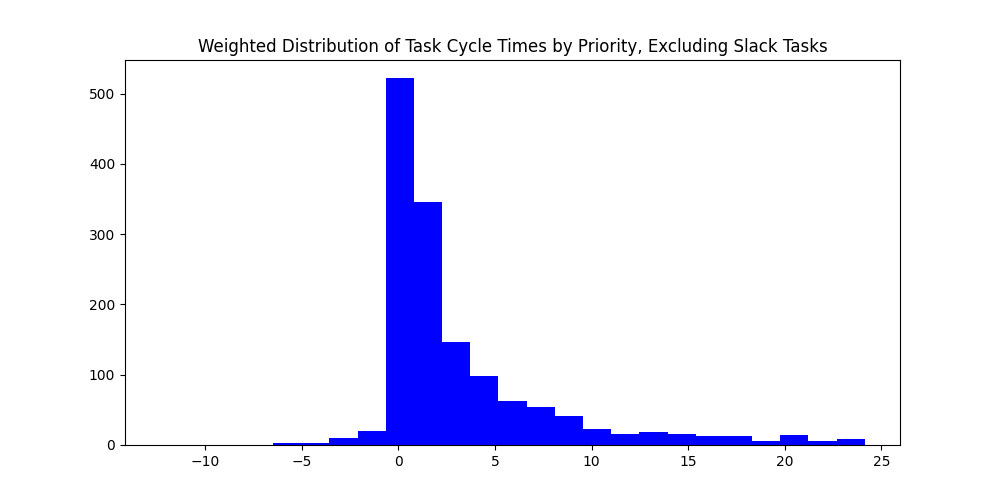

In [6]:
# CYCLE TIMES EXCLUDING TASKS MENTIONING SLACK AND WEIGHTED BY PRIORITY
tasks_no_slack = sorted([t for t in tasks if t.done and not 'slack' in t.data["doc"]["title"].lower()], key=lambda t: t.cycle_time)
cycle_times_no_slack = [t.cycle_time for t in tasks_no_slack]

q1, q3, n5, n9 = np.percentile(cycle_times_no_slack, [25, 75, 95, 99])
iqr = q3 - q1
outer_fence = q3 + 3*(iqr)

print("NOTE: Negative cycle times are recurring tasks that were marked 'done' before the date of recurrence.")

print(f"""
Q1: {q1}
Q3: {q3}
IQR: {iqr}
outer_fence: {outer_fence}
95th: {n5}
99th: {n9}
""")

# Filter Outliers
outliers = [t for t in tasks_no_slack if t.cycle_time >= outer_fence]
print(f"{len(outliers)} outliers of {len(tasks_no_slack)}: {outliers[:3]} ... {outliers[-3:]}")

tasks_no_slack_or_outliers = [t for t in tasks_no_slack if t not in outliers]
cycles_no_slack_or_outliers = [t.cycle_time for t in tasks_no_slack_or_outliers]
weights = [t.is_starred/3 for t in tasks_no_slack_or_outliers]

# Plot it
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(
    cycles_no_slack_or_outliers,
    bins=math.ceil(max(cycles_no_slack_or_outliers)),
    weights=weights,
    histtype ='bar',
    facecolor='blue',
)
ax.title.set_text("Weighted Distribution of Task Cycle Times by Priority, Excluding Slack Tasks")
mplcursors.cursor(hover=True)